In [1]:
from statsbombpy import sb
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from mplsoccer import Pitch

In [49]:
#Get all UEFA EURO 2024 matches
matches = sb.matches(season_id=282,competition_id=55)


spain_matches = matches[
    (matches['home_team'] == 'Spain') | (matches['away_team'] == 'Spain')
].copy()

spain_matches[['match_id', 'home_team', 'away_team', 'match_date']]

events = sb.events(match_id=3943043)

In [79]:
def plot_pass_network(match_id,team_name,min_passes=5):
    #Load event data
    events = sb.events(match_id=match_id)
    passes = events[
        (events['type']=='Pass') & 
        (events['team']==team_name) &
        (events['pass_type']!='Throw-In') & 
        (events['pass_outcome'].isna())
    ]

    passes = passes[['player', 'pass_recipient', 'location', 'pass_end_location']].dropna()
    passes[['x', 'y']] = pd.DataFrame(passes['location'].tolist(), index=passes.index)
    passes[['end_x', 'end_y']] = pd.DataFrame(passes['pass_end_location'].tolist(), index=passes.index)

    # Network graph
    G = nx.DiGraph()
    for _, row in passes.iterrows():
        passer = row['player']
        recipient = row['pass_recipient']
        if G.has_edge(passer, recipient):
            G[passer][recipient]['weight'] += 1
        else:
            G.add_edge(passer, recipient, weight=1)

    # Remove weak edges
    G.remove_edges_from([(u, v) for u, v, d in G.edges(data=True) if d['weight'] < min_passes])

    #Compute centrality
    centrality = nx.degree_centrality(G)
    
    avg_locs = passes.groupby('player')[['x', 'y']].mean()

    pitch = Pitch(pitch_color='grass',line_color='white',stripe=True)
    fig, ax = pitch.draw(figsize=(10, 7))

    for player, (x, y) in avg_locs.iterrows():
        size = centrality.get(player, 0) * 3000
        ax.scatter(x, y, s=size, color='skyblue', edgecolor='black', zorder=3)
        ax.text(x, y, player.split()[0], fontsize=9, ha='center', va='center', zorder=4)

    for u, v, d in G.edges(data=True):
        if u in avg_locs.index and v in avg_locs.index:
            x1, y1 = avg_locs.loc[u]
            x2, y2 = avg_locs.loc[v]
            ax.annotate("", xy=(x2, y2), xytext=(x1, y1),
                        arrowprops=dict(arrowstyle="-", lw=d['weight'] * 0.3, color='pink'),
                        zorder=2)

    ax.set_title(f"{team_name} Pass Network – (Match ID: {match_id})", fontsize=16)
    plt.show()
    plt.close(fig)



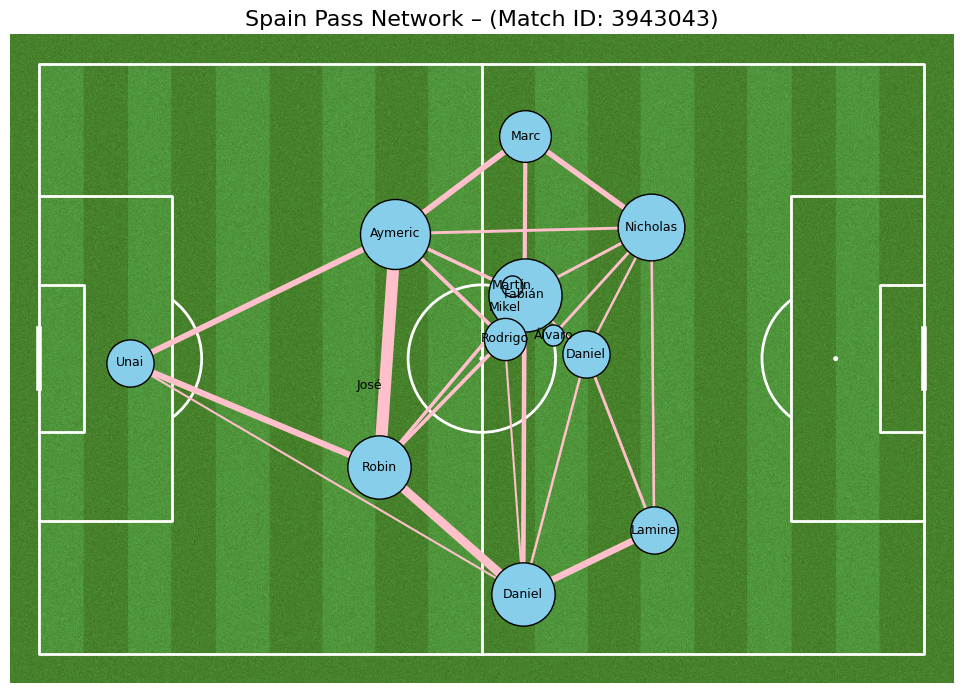

In [80]:
plot_pass_network(match_id=3943043,team_name='Spain')
#plt.close(fig)